# Hate Speech Analysis with BERT
Based on: University of Mannheim – Web Mining – Lab 4, [blog post 1](https://curiousily.com/posts/create-dataset-for-sentiment-analysis-by-scraping-google-play-app-reviews-using-python/), [blog post 2](https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/), [blog post 3](https://mccormickml.com/2019/07/22/BERT-fine-tuning/), and the [BERT Fine-Tuning Tutorial](https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP#scrollTo=EKOTlwcmxmej) with PyTorch by Chris McCormick and Nick Ryan.


In [ ]:
# enable GPU processing
import torch


if torch.cuda.is_available():    
  
    device = torch.device("cuda")



else:
    device = torch.device("cpu")

In [ ]:
!pip install transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/SMA_Project/Hate speech tweets data"

/content/drive/My Drive/SMA_Project/Hate speech tweets data


In [ ]:
# From https://www.kaggle.com/vkrahul/twitter-hate-speech?select=test_tweets_anuFYb8.csv
import pandas as pd
df = pd.read_csv("train_E6oV3lV.csv")
print(df.columns)
df = df[['label', 'tweet']]
df.head(5)

Index(['id', 'label', 'tweet'], dtype='object')


,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'Non-hate'), Text(0, 0, 'Hate')]

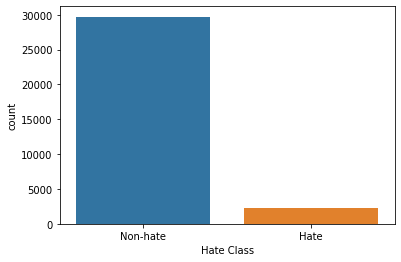

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.countplot(df.label)
class_names = ['Non-hate', 'Hate']
plt.xlabel('Hate Class')
ax.set_xticklabels(class_names)

In [ ]:
# Make our input and label data as a list of instances
all_texts = list(df.tweet)
all_labels = list(df.label)

## Preprocessing


In [ ]:
!pip install emoji
import emoji

     |████████████████████████████████| 133kB 23.5MB/s 


In [ ]:
import re
def process_tweet(tweet):
    return " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])", " ",emoji.demojize(tweet.lower())).split())

all_texts_preprocessed = [process_tweet(t) for t in all_texts]

In [ ]:
print(all_texts_preprocessed[0:20])

['when a father is dysfunctional and is so selfish he drags his kids into his dysfunction run', 'thanks for lyft credit i can t use cause they don t offer wheelchair vans in pdx disapointed getthanked', 'bihday your majesty', 'model i love u take with u all the time in ur', 'factsguide society now motivation', '2 2 huge fan fare and big talking before they leave chaos and pay disputes when they get there allshowandnogo', 'camping tomorrow danny', 'the next school year is the year for exams can t think about that school exams hate imagine actorslife revolutionschool girl', 'we won love the land allin cavs champions cleveland clevelandcavaliers', 'welcome here i m it s so gr8', 'ireland consumer price index mom climbed from previous 0 2 to 0 5 in may blog silver gold forex', 'we are so selfish orlando standwithorlando pulseshooting orlandoshooting biggerproblems selfish heabreaking values love', 'i get to see my daddy today 80days gettingfed', 'cnn calls michigan middle school build the 

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import random
import torch
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

In [ ]:
# And we'll perform the same split with same ratio and random seed, 
# so as to compare with our sklearn model from last tutorial
X_train, X_test, y_train, y_test = train_test_split(all_texts_preprocessed, all_labels, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_SEED, shuffle=True)
print(len(X_train), len(X_val), len(X_test))

25569 3196 3197


## Tokenization


In [ ]:
from transformers import BertTokenizer
# Specify the pre-trained model 
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# Print the preprocessed review text
print('Preprocessed Text: {}'.format(X_train[2]))

# Print the text split into tokens
print('Tokens: {}'.format(tokenizer.tokenize(X_train[2])))

# Print the tokens mapped to token ids
print('Token IDs: {}'.format(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(X_train[2]))))

Preprocessed Text: friday gdegblog friday selfie beard gayguy gaymen gaystyle lifestyle fullness
Tokens: ['friday', 'g', '##de', '##gb', '##log', 'friday', 'self', '##ie', 'beard', 'gay', '##gu', '##y', 'gay', '##men', 'gay', '##sty', '##le', 'lifestyle', 'full', '##ness']
Token IDs: [5958, 1043, 3207, 18259, 21197, 5958, 2969, 2666, 10154, 5637, 12193, 2100, 5637, 3549, 5637, 21756, 2571, 9580, 2440, 2791]


##  Input Formatting



In [ ]:
# Print the preprocessed review text.
print('Preprocessed Text: {}'.format(X_train[2]))

# Encode the preprocessed text by using encode_plus function
encoded = tokenizer.encode_plus(
                          text=X_train[2],
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]' and [PAD]
                          max_length=64,      # Pad & truncate all texts 
                          pad_to_max_length = True,
                          return_token_type_ids=False,
                          return_attention_mask = True, # Construct attention masks
                          return_tensors = 'pt', # Return pytorch tensors
                    )
print('input_ids: {}'.format(encoded['input_ids']))
print('attention_mask: {}'.format(encoded['attention_mask']))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Preprocessed Text: friday gdegblog friday selfie beard gayguy gaymen gaystyle lifestyle fullness
input_ids: tensor([[  101,  5958,  1043,  3207, 18259, 21197,  5958,  2969,  2666, 10154,
          5637, 12193,  2100,  5637,  3549,  5637, 21756,  2571,  9580,  2440,
          2791,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]])
attention_mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
class TweetDataset(Dataset):

  def __init__(self, tweets, labels, tokenizer, max_len):
    self.tweets = tweets
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.tweets)

  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True, 
      max_length=self.max_len, 
      pad_to_max_length=True,
      return_token_type_ids=False,
      return_attention_mask=True, 
      return_tensors='pt', 
    )
    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(label, dtype=torch.long)
    }

We also return the review texts, so it’ll be easier to evaluate the predictions from our model.

In [ ]:
def create_data_loader(X, Y, tokenizer, max_len, batch_size, num_workers=2, sampler = None):
  ds = TweetDataset(
    tweets=np.array(X),
    labels=np.array(Y),
    tokenizer=tokenizer,
    max_len=max_len
  )
  if sampler!=None:
    sampler = sampler(ds)

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=num_workers,
    sampler = sampler
  )

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
MAX_LEN = 128
BATCH_SIZE = 32

# Create the DataLoaders for our training and validation sets.
# Take training samples in random order.
train_data_loader = create_data_loader(X_train, y_train, tokenizer, MAX_LEN, BATCH_SIZE, sampler = RandomSampler) # Select batches randomly

# For validation & testing samples, the order doesn't matter, just read them sequentially.
val_data_loader = create_data_loader(X_val, y_val, tokenizer, MAX_LEN, BATCH_SIZE, sampler = SequentialSampler) # Pull out batches sequentially.

test_data_loader = create_data_loader(X_test, y_test, tokenizer, MAX_LEN, BATCH_SIZE, sampler = SequentialSampler) # Pull out batches sequentially.

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    PRE_TRAINED_MODEL_NAME, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## Fine-Tuning & Evaluation



In [ ]:

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 1e-3
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-6.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4 (depend on the usage, you can also set it larger)
# We chose to run for 3
EPOCHS = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_data_loader) * EPOCHS

# Create the learning rate scheduler, here we use a linear scheduler with no warmup steps
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# Define our loss function
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
# Training
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model.train()
  total_train_accuracy = 0
  total_train_loss = 0
  losses = []
  correct_predictions = 0
  for step, batch in enumerate(data_loader):
    if step % 40 == 0 and not step == 0:
       print('Batch: {}  of  {}'.format(step, len(data_loader)))
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    model.zero_grad()
    outputs = model(
      input_ids=input_ids,
      token_type_ids=None,
      attention_mask=attention_mask,
      labels=labels
    )
    loss = outputs[0]
    total_train_loss += loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    logits = outputs[1].detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()
    total_train_accuracy += flat_accuracy(logits, label_ids)
  # Calculate the average loss over all of the batches.
  avg_train_accuracy = total_train_accuracy / len(data_loader)
  avg_train_loss = total_train_loss / len(data_loader) 
  return avg_train_accuracy, avg_train_loss

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Evaluation
from sklearn.metrics import classification_report
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model.eval()
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0
  losses = []
  correct_predictions = 0
  y_pred = []
  y_true = []

  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["labels"].to(device)
      outputs = model(
        input_ids=input_ids,
        token_type_ids=None,
        attention_mask=attention_mask,
        labels=labels,
        return_dict=False
      )
      total_eval_loss += outputs[0].item()
      logits = outputs[1].detach().cpu().numpy()
      label_ids = labels.to('cpu').numpy()
      total_eval_accuracy += flat_accuracy(logits, label_ids)
      _, output = outputs
      y_pred.extend(torch.argmax(output, 1).tolist())
      y_true.extend(labels.tolist())

  print(classification_report(y_true, y_pred))
  avg_val_accuracy = total_eval_accuracy / len(data_loader)
  avg_val_loss = total_eval_loss / len(data_loader)
  #print("Accuracy: {0:.2f}".format(avg_val_accuracy))
  #print("Validation Loss: {0:.2f}".format(avg_val_loss))
  return avg_val_accuracy, avg_val_loss

In [ ]:
%%time
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print('Epoch: {}/{}'.format(epoch+1, EPOCHS))
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(X_train)
  )
  print('Train loss: {}, Accuracy: {}'.format(train_loss, train_acc))
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(X_val)
  )
  print('Val loss: {}, Accuracy: {}'.format(val_loss, val_acc))
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch: 1/3
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Batch: 40  of  800
Batch: 80  of  800
Batch: 120  of  800
Batch: 160  of  800
Batch: 200  of  800
Batch: 240  of  800
Batch: 280  of  800
Batch: 320  of  800
Batch: 360  of  800
Batch: 400  of  800
Batch: 440  of  800
Batch: 480  of  800
Batch: 520  of  800
Batch: 560  of  800
Batch: 600  of  800
Batch: 640  of  800
Batch: 680  of  800
Batch: 720  of  800
Batch: 760  of  800
Train loss: 0.14512151380375143, Accuracy: 0.953046875


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val loss: 0.11901982126757503, Accuracy: 0.9565178571428571

Epoch: 2/3
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Batch: 40  of  800
Batch: 80  of  800
Batch: 120  of  800
Batch: 160  of  800
Batch: 200  of  800
Batch: 240  of  800
Batch: 280  of  800
Batch: 320  of  800
Batch: 360  of  800
Batch: 400  of  800
Batch: 440  of  800
Batch: 480  of  800
Batch: 520  of  800
Batch: 560  of  800
Batch: 600  of  800
Batch: 640  of  800
Batch: 680  of  800
Batch: 720  of  800
Batch: 760  of  800
Train loss: 0.0673841806749988, Accuracy: 0.9787890625


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val loss: 0.1206263075734023, Accuracy: 0.9677678571428571

Epoch: 3/3
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Batch: 40  of  800
Batch: 80  of  800
Batch: 120  of  800
Batch: 160  of  800
Batch: 200  of  800
Batch: 240  of  800
Batch: 280  of  800
Batch: 320  of  800
Batch: 360  of  800
Batch: 400  of  800
Batch: 440  of  800
Batch: 480  of  800
Batch: 520  of  800
Batch: 560  of  800
Batch: 600  of  800
Batch: 640  of  800
Batch: 680  of  800
Batch: 720  of  800
Batch: 760  of  800
Train loss: 0.030668435036059236, Accuracy: 0.99140625


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val loss: 0.14747742476232817, Accuracy: 0.966830357142857

CPU times: user 27min 41s, sys: 12.3 s, total: 27min 54s
Wall time: 28min 15s


In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(X_test)
)
print('Testing Accuracy: {}'.format(test_acc.item()))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2970
           1       0.85      0.69      0.76       227

    accuracy                           0.97      3197
   macro avg       0.91      0.84      0.87      3197
weighted avg       0.97      0.97      0.97      3197

Testing Accuracy: 0.9693426724137931


In [ ]:

def predict_model(model, data_loader, loss_fn, device, n_examples):
  model.eval()

  y_pred = []

  nb_eval_steps = 0
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["labels"].to(device)
      outputs = model(
        input_ids=input_ids,
        token_type_ids=None,
        attention_mask=attention_mask,
        labels=labels,
        return_dict=False
      )
      _, output = outputs
      y_pred.extend(torch.argmax(output, 1).tolist())

      logits = outputs[1].detach().cpu().numpy()
      label_ids = labels.to('cpu').numpy()


  return y_pred

In [ ]:
import pandas as pd
df_pred = pd.read_excel("Tweets_cleaned.xlsx")
X_pred = list(df_pred.text)
y_dummy = [0 for i in X_pred]
import re
def process_tweet(tweet):
    return " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])", " ",emoji.demojize(tweet.lower())).split())

X_pred = [process_tweet(t) for t in X_pred]
X_pred[0:10]

['doesn t vaccine approval typically take 6and months just asking as i m not too familiar with their process',
 'you re right too bad this vaccine doesn t have decades of research which is why i dont trust it',
 'the vaccine is free red heart',
 'the world needs covid19 vaccine access now the g7 must step up to endthepandemic for all by sharing 1 billion doses through covax by september globe showing europe africa httpsskeptical annoyed undecided uneasy or hesitantt coepv4fnzfou',
 'but you can get it i remember getting my mumps vax never got mumps polio never got it httpsskeptical annoyed undecided uneasy or hesitantt cowgul6tgiml',
 'self preservation duh you understand how a virus and pandemic work if you d like the dollar1 50 you contributed back then we re more than happy to charge you for your free vaccine j f c',
 'yep but it s not nearly even close to as bad as the media makes it and no one can deny that vaccine made that fast is a sure bet they usually take around 10 years',
 

In [ ]:
pred_data_loader = create_data_loader(X_pred, y_dummy, tokenizer, MAX_LEN, BATCH_SIZE, sampler = SequentialSampler) # Pull out batches sequentially.

In [ ]:
y_pred = predict_model(
  model,
  pred_data_loader,
  loss_fn,
  device,
  len(X_pred)
)
y_pred

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
len(y_pred)
len(X_pred)

22534

In [ ]:
df_pred["Hate"] = y_pred

In [ ]:
df_pred[df_pred["Hate"]==1].head(20)

,text,user screen name,user followers,url,created at,replies,retweets,likes,mention,Hate
27,What was Trump’s vaccine? Bleach? Or the dewor...,lovewurthy,24,http://twitter.com/download/iphone,2021-06-10 19:14:52,0,0,0,"VickieGardens,daveonuevo,POTUS",1
30,How can we trust while she ignores prior-infe...,AlDiPaolo,8,http://twitter.com/download/iphone,2021-06-10 19:14:19,0,0,0,"noorchashm,POTUS,WhiteHouse,SenRonJohnson,Rand...",1
51,correction tax payers paid for the 500 million...,BartCooper12,134,http://twitter.com/download/iphone,2021-06-10 19:09:31,0,0,0,POTUS,1
66,administration Dem leadership has found fundin...,pitch4kdemocrat,724,https://mobile.twitter.com,2021-06-10 19:07:04,0,1,1,"SenSanders,wccjtsan,JoeBiden",1
68,Isn't the vaccine a weapon against a deadly vi...,Tonism,1075,https://mobile.twitter.com,2021-06-10 19:06:33,0,0,0,"sororalice,VP,POTUS",1
106,If Bill Gates says the vaccine is safe then I'...,TastyChia,859,http://twitter.com/download/android,2021-06-10 18:59:10,0,0,1,"VP,POTUS",1
115,Don’t you mean to say “open to harm by recomme...,SpiderM51,68,http://twitter.com/download/iphone,2021-06-10 18:56:35,0,0,0,"noorchashm,CDCDirector,CDCgov,US_FDA,TuckerCar...",1
129,Pfizer’s vaccine was developed by Turkish Germ...,Rob_Smithers,193,http://twitter.com/download/iphone,2021-06-10 18:52:56,0,1,21,"bigskywillie,POTUS",1
134,... it's like a vaccine phobia..in fact there'...,WaldorickWilson,522,http://twitter.com/download/android,2021-06-10 18:52:32,0,0,0,"Hope_doubtful,JoeBiden",1
147,You mean the former twice impeached cheeto tha...,FadeawayLa,7,http://twitter.com/download/android,2021-06-10 18:49:49,0,0,4,"DugDugGuy13,POTUS",1


In [ ]:
df_pred.to_excel("Tweets_Hate2.xlsx", index=False)

In [ ]:
df_pred2 = pd.read_excel("Tweets_Hate.xlsx")

In [ ]:
df_con = pd.concat([df_pred, df_pred2], axis=1)
df_con.head(50)

,text,user screen name,user followers,url,created at,replies,retweets,likes,mention,Hate,text,user screen name,user followers,url,created at,replies,retweets,likes,mention,Hate
0,Doesn't vaccine approval typically take 6and m...,spadesgeek,19,https://mobile.twitter.com,2021-06-10 19:24:27,0,0,0,"MatthewDavidH,EricTopol,TheEconomist,US_FDA,la...",0,Doesn't vaccine approval typically take 6and m...,spadesgeek,19,https://mobile.twitter.com,2021-06-10 19:24:27,0,0,0,"MatthewDavidH,EricTopol,TheEconomist,US_FDA,la...",0
1,You're right too bad this vaccine doesn't have...,selirodz,78,http://twitter.com/download/android,2021-06-10 19:24:26,0,0,0,"DharkArk,JoeBiden",0,You're right too bad this vaccine doesn't have...,selirodz,78,http://twitter.com/download/android,2021-06-10 19:24:26,0,0,0,"DharkArk,JoeBiden",0
2,The vaccine is free…red heart️,FlowerGirlBaker,1486,http://twitter.com/#!/download/ipad,2021-06-10 19:23:57,0,0,0,"theredshift11,POTUS,studentsfordemo",0,The vaccine is free…red heart️,FlowerGirlBaker,1486,http://twitter.com/#!/download/ipad,2021-06-10 19:23:57,0,0,0,"theredshift11,POTUS,studentsfordemo",0
3,. the world needs COVID19 vaccine access ...,DevizesGreens,150,https://mobile.twitter.com,2021-06-10 19:23:49,0,0,0,"BorisJohnson,JustinTrudeau,POTUS,EUCouncil,Reg...",0,. the world needs COVID19 vaccine access ...,DevizesGreens,150,https://mobile.twitter.com,2021-06-10 19:23:49,0,0,0,"BorisJohnson,JustinTrudeau,POTUS,EUCouncil,Reg...",0
4,But you can get it.\nI remember getting my Mum...,canfixstoopid,355,https://mobile.twitter.com,2021-06-10 19:23:42,0,0,0,"SerendipityOr,Shockwave_Shaun,Ozymandiyaas,Joe...",0,But you can get it.\nI remember getting my Mum...,canfixstoopid,355,https://mobile.twitter.com,2021-06-10 19:23:42,0,0,0,"SerendipityOr,Shockwave_Shaun,Ozymandiyaas,Joe...",0
5,Self-Preservation. Duh. You understand how a v...,noondlyt,8365,http://twitter.com/download/iphone,2021-06-10 19:23:23,0,0,0,"FFairing,POTUS",0,Self-Preservation. Duh. You understand how a v...,noondlyt,8365,http://twitter.com/download/iphone,2021-06-10 19:23:23,0,0,0,"FFairing,POTUS",0
6,Yep. But it's not nearly even close to as bad ...,jarrodjcain,28,https://mobile.twitter.com,2021-06-10 19:21:47,0,0,0,"damnjoeshere,human_stealth,FFairing,POTUS",0,Yep. But it's not nearly even close to as bad ...,jarrodjcain,28,https://mobile.twitter.com,2021-06-10 19:21:47,0,0,0,"damnjoeshere,human_stealth,FFairing,POTUS",0
7,Maybe clearing student debt would be a great m...,badwolfreigns,2478,http://twitter.com/download/android,2021-06-10 19:21:45,0,0,0,JoeBiden,0,Maybe clearing student debt would be a great m...,badwolfreigns,2478,http://twitter.com/download/android,2021-06-10 19:21:45,0,0,0,JoeBiden,0
8,I didn’t say there was anything wrong with the...,mclanea,4054,http://twitter.com/download/iphone,2021-06-10 19:21:34,0,0,0,"Belltower,SpeakerPelosi,POTUS,VP",0,I didn’t say there was anything wrong with the...,mclanea,4054,http://twitter.com/download/iphone,2021-06-10 19:21:34,0,0,0,"Belltower,SpeakerPelosi,POTUS,VP",0
9,A lot of people have doubts on the Vaccine. A ...,IyanaAmes1,2,http://twitter.com/download/iphone,2021-06-10 19:21:20,0,0,0,"Hope_doubtful,JoeBiden",0,A lot of people have doubts on the Vaccine. A ...,IyanaAmes1,2,http://twitter.com/download/iphone,2021-06-10 19:21:20,0,0,0,"Hope_doubtful,JoeBiden",0
